/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training...
Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.8768 - loss: 0.4642 - val_accuracy: 0.8265 - val_loss: 0.6728
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.9503 - loss: 0.1824 - val_accuracy: 0.9075 - val_loss: 0.4887
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9632 - loss: 0.1407 - val_accuracy: 0.9566 - val_loss: 0.1512
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9667 - loss: 0.1250 - val_accuracy: 0.9635 - val_loss: 0.1526
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9702 - loss: 0.1016 - val_accuracy: 0.9378 - val_loss: 0.2748
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9708 - loss: 0.1036 - val_accuracy: 0.9623 - val_loss: 0.1553
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9756 - loss: 0.0864 - val_accuracy: 0.9612 - val_loss: 0.1687
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.

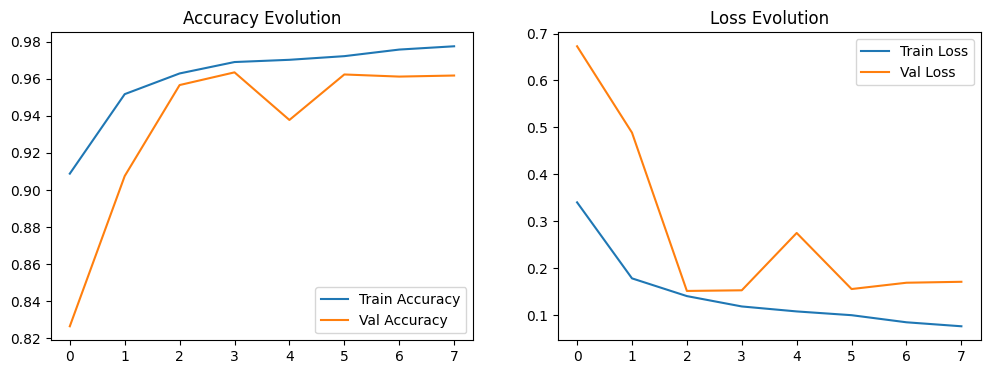

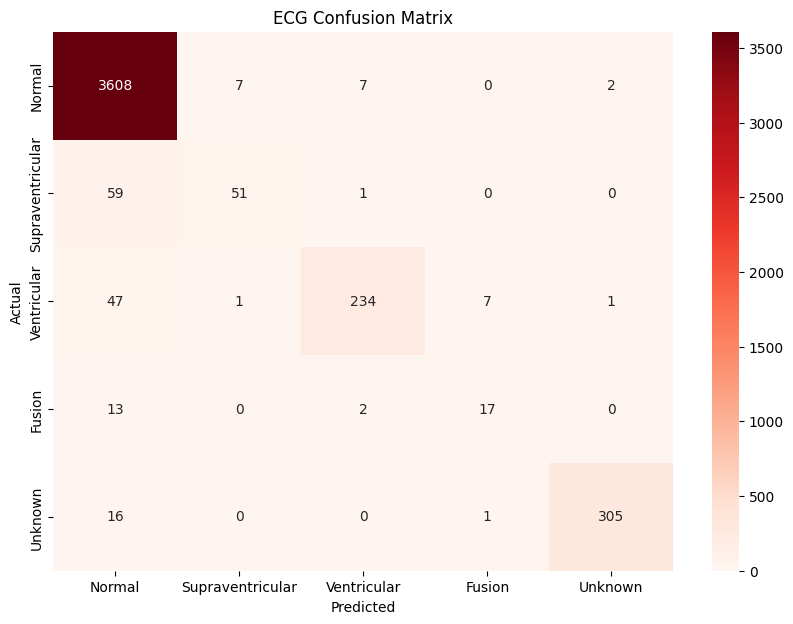

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. LOAD DATA
try:
    df = pd.read_csv('mitbih_test.csv', header=None)
except FileNotFoundError:
    from google.colab import files
    print("Please upload mitbih_test.csv")
    uploaded = files.upload()
    df = pd.read_csv('mitbih_test.csv', header=None)

# 2. PREPROCESSING
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(int)

# Reshape features for 1D CNN: (Samples, Time Steps, Channels)
X = X.reshape(X.shape[0], X.shape[1], 1)

# One-hot encode the labels
y_categorical = tf.keras.utils.to_categorical(y, num_classes=5)

# Split into Training and Testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# 3. BUILD THE 1D CNN MODEL
model = models.Sequential([
    # First Convolutional Block
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(187, 1)),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=3, strides=2),

    # Second Convolutional Block
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=3, strides=2),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Helps prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax') # 5 Classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. TRAIN THE MODEL
print("Starting training...")
# Early stopping prevents wasting time if the model stops improving
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# 5. GENERATE THE REPORT
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

print("\n" + "="*40)
print("  CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_true, y_pred, target_names=class_names))

# 6. VISUALIZE RESULTS
# Plot Training Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ECG Confusion Matrix')
plt.show()